In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [4]:
def inspect_images(directory):
    """Remove corrupted or invalid image files."""
    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file)
            try:
                img = Image.open(filepath)
                img.verify()  # Verify that the file is a valid image
            except Exception as e:
                print(f"Removing corrupted file: {filepath}, Error: {e}")
                os.remove(filepath)

inspect_images("PetImages")

In [5]:
input_path = []
label = []

for class_name in os.listdir("PetImages"):
    for path in os.listdir(os.path.join("PetImages", class_name)):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("PetImages", class_name, path))

df = pd.DataFrame({'images': input_path, 'label': label})
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle data

In [6]:
def clean_dataframe(df):
    df = df[df['images'].str.contains('.jpg|.png')]  # Keep only valid image formats
    invalid_files = ['PetImages/Dog/Thumbs.db', 'PetImages/Cat/Thumbs.db']
    df = df[~df['images'].isin(invalid_files)]
    return df

df = clean_dataframe(df)


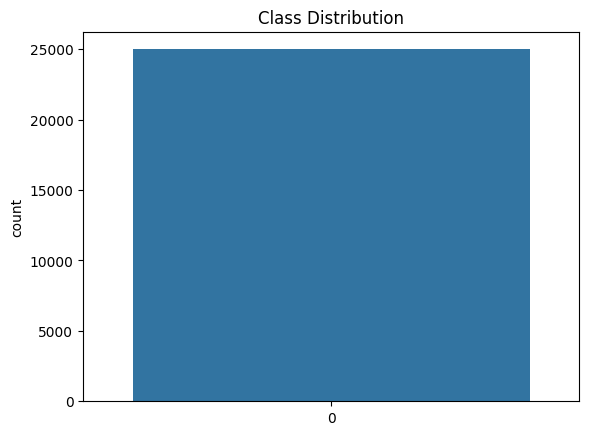

In [7]:
sns.countplot(df['label'])
plt.title('Class Distribution')
plt.show()


In [11]:
# Split dataset into training and testing
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Ensure labels are strings for binary classification
train['label'] = train['label'].astype(str)
test['label'] = test['label'].astype(str)

# Data augmentation for training
train_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_generator = ImageDataGenerator(rescale=1.0 / 255)

# Flow from DataFrame
target_size = (128, 128)
batch_size = 64

train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col='images',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col='images',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [12]:
# Build the CNN model
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPool2D((2,2)),
    Dropout(0.25),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.25),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,447,137 (24.59 MB)

 Trainable params: 6,447,137 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
history = model.fit(
    train_iterator,
    epochs=10,
    validation_data=val_iterator
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 889s 3s/step - accuracy: 0.5112 - loss: 0.8652 - val_accuracy: 0.5552 - val_loss: 0.6813
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 765s 2s/step - accuracy: 0.5718 - loss: 0.6787 - val_accuracy: 0.6536 - val_loss: 0.6374
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 745s 2s/step - accuracy: 0.6421 - loss: 0.6348 - val_accuracy: 0.6912 - val_loss: 0.5832
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 633s 2s/step - accuracy: 0.6732 - loss: 0.6035 - val_accuracy: 0.7092 - val_loss: 0.5626
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 518s 2s/step - accuracy: 0.6977 - loss: 0.5733 - val_accuracy: 0.7416 - val_loss: 0.5229
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - accuracy: 0.7089 - loss: 0.5612 - val_accuracy: 0.7558 - val_loss: 0.5003
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1953s 6s/step - accuracy: 0.7177 - loss: 0.5463 - val_accuracy: 0.7548 - val_loss: 0.4869
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 574s 2s/step - accuracy: 0.7336 - loss: 0.5210 - val_acc

In [15]:
# Save the model in recommended format
model.save("model.keras")

In [16]:
# Load and predict with the model
def predict_image(model, image_path, target_size):
    """Predict if an image is a cat or dog."""
    if not os.path.exists(image_path):
        raise ValueError(f"Image path {image_path} does not exist.")
    img = load_img(image_path, target_size=target_size)
    img = np.array(img) / 255.0  # Normalize the image
    img = img.reshape(1, *target_size, 3)  # Reshape for prediction
    pred = model.predict(img)
    return 'Dog' if pred[0] > 0.5 else 'Cat'

In [17]:
# Test prediction
model = load_model("model.keras")
image_path = "test1.jpg"  # Replace with your test image path
label = predict_image(model, image_path, target_size)
print(f"Prediction: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Prediction: Cat


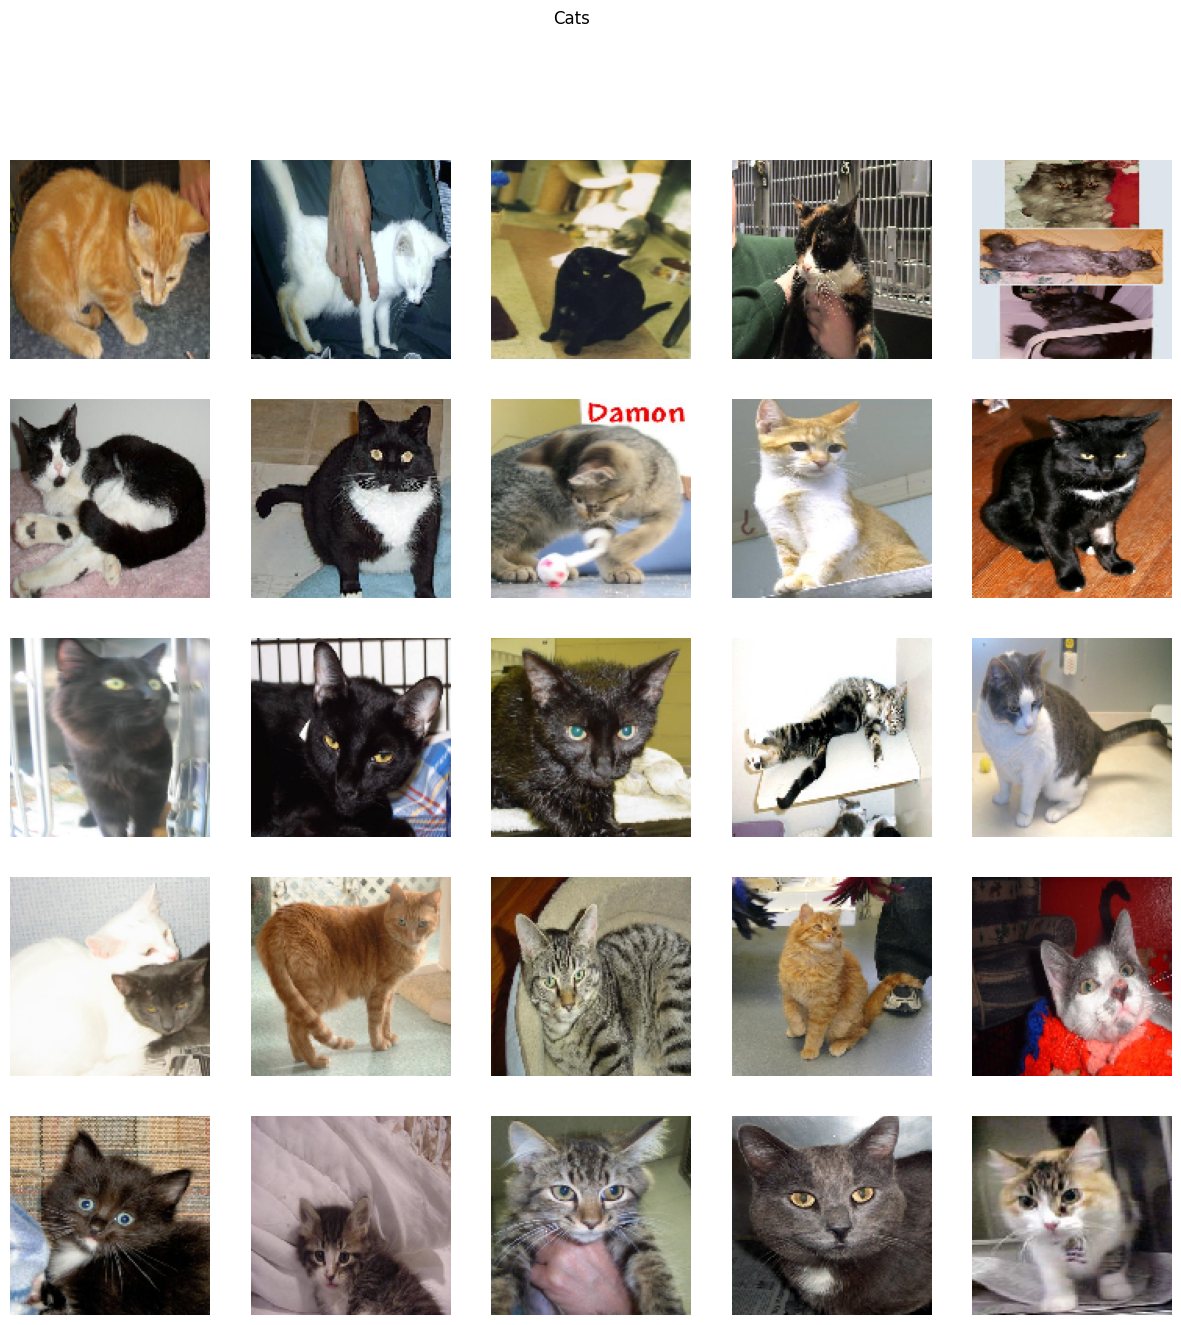

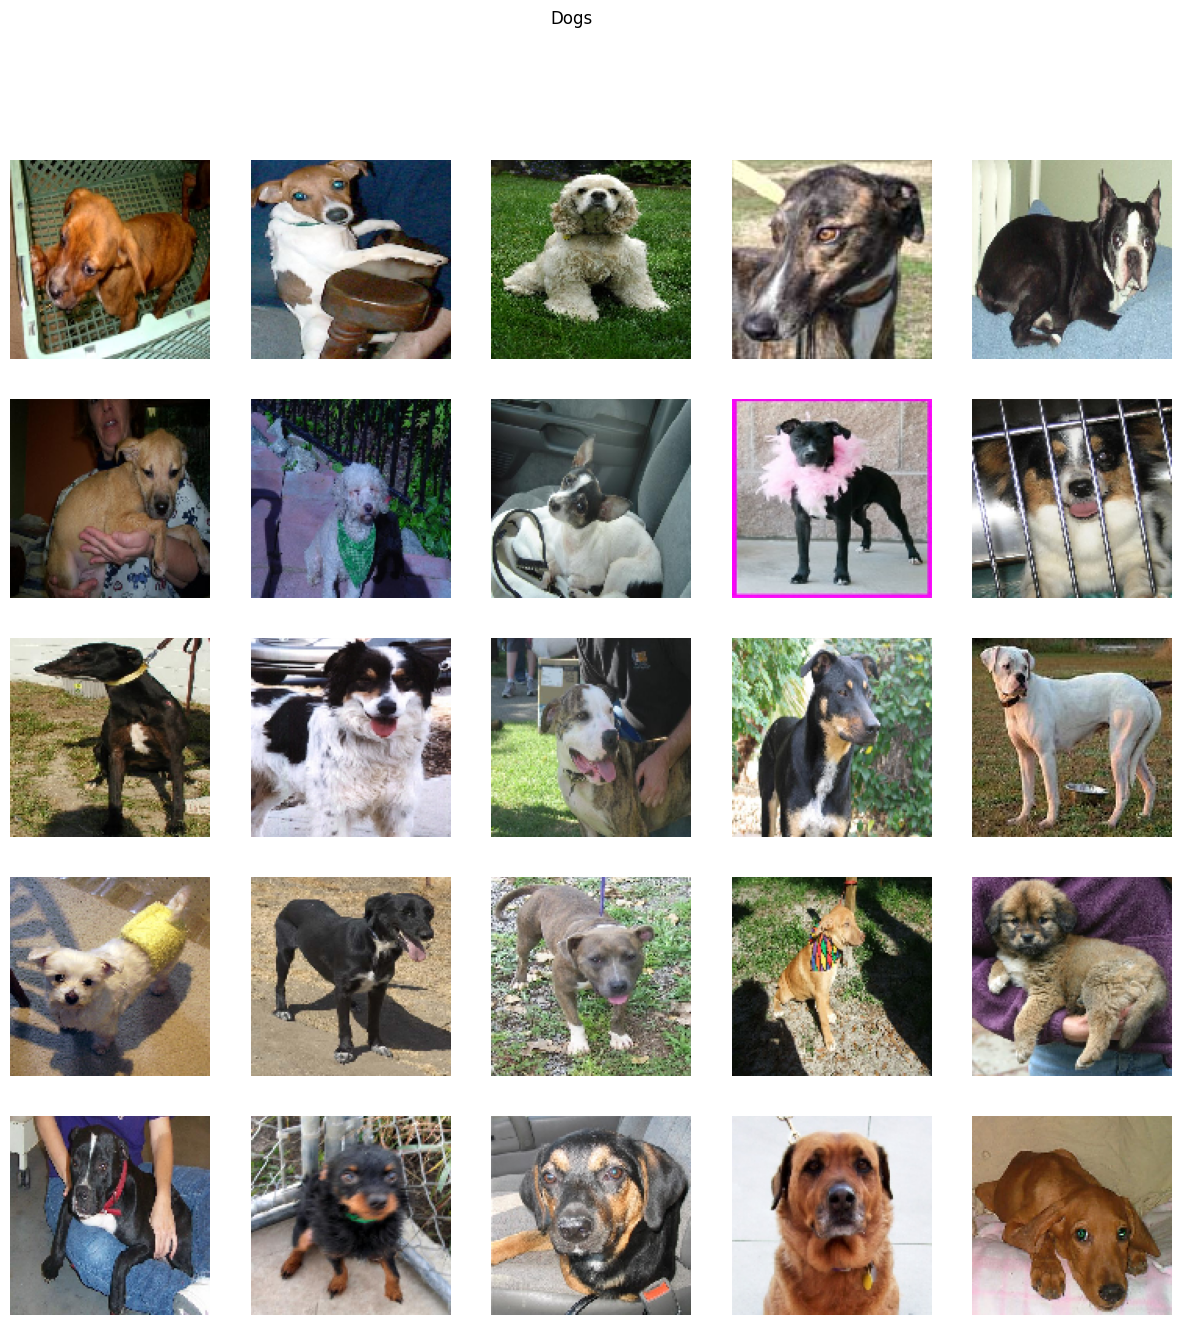

In [18]:
# Visualize random images for sanity check
def visualize_images(df, label, title):
    plt.figure(figsize=(15, 15))
    temp = df[df['label'] == label]['images']
    start = random.randint(0, len(temp))
    files = temp[start:start+25]

    for index, file in enumerate(files):
        plt.subplot(5, 5, index+1)
        img = load_img(file, target_size=(128, 128))
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

visualize_images(df, label=0, title="Cats")
visualize_images(df, label=1, title="Dogs")
